### Celda 1: Importaciones y Configuración

Copiamos las librerías necesarias y configuramos los gráficos para que se vean bien.

In [19]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Configuración de estilo visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

### Celda 2: Carga y Preprocesamiento

Al igual que en el eejercicio 1. Extraemos solo las estadísticas base (HP, Attack, etc.) y las normalizamos.

In [20]:
# Cargar el JSON
with open('pokemons-1.json', 'r') as f:
    data = json.load(f)

# Aplanar el JSON a un DataFrame
rows = []
for name, info in data['pokedex'].items():
    stats = info.get('stats', {})
    types = info.get('types', [])
    
    row = {
        'name': name,
        'hp': stats.get('hp', 0),
        'atk': stats.get('atk', 0),
        'def': stats.get('def', 0),
        'spa': stats.get('spa', 0),
        'spd': stats.get('spd', 0),
        'spe': stats.get('spe', 0),
        'type1': types[0] if len(types) > 0 else 'Unknown',
        'hasEvo': info.get('hasEvo', 0)
    }
    rows.append(row)

df = pd.DataFrame(rows)

# Selección de características para el Clustering
# Nos enfocamos en las estadísticas de combate (funcionalidad)
features = ['hp', 'atk', 'def', 'spa', 'spd', 'spe']
X = df[features]

# Escalado de Datos
# El clustering jerárquico se basa en distancias, si no escalamos, la estadística con números más grandes (ej. HP) dominará el agrupamiento.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Datos procesados: {X_scaled.shape[0]} Pokémons con {X_scaled.shape[1]} características.")
df.head()

Datos procesados: 734 Pokémons con 6 características.


,name,hp,atk,def,spa,spd,spe,type1,hasEvo
0,bulbasaur,45,49,49,65,65,45,Grass,1
1,ivysaur,60,62,63,80,80,60,Grass,1
2,venusaur,80,82,83,100,100,80,Grass,0
3,charmander,39,52,43,60,50,65,Fire,1
4,charmeleon,58,64,58,80,65,80,Fire,1


### Celda 3: Generación del Dendrograma

Generamos el dendrograma para visualizar la estructura jerárquica. Usaremos el método Ward porque suele generar los clústeres más equilibrados y visualmente claros.

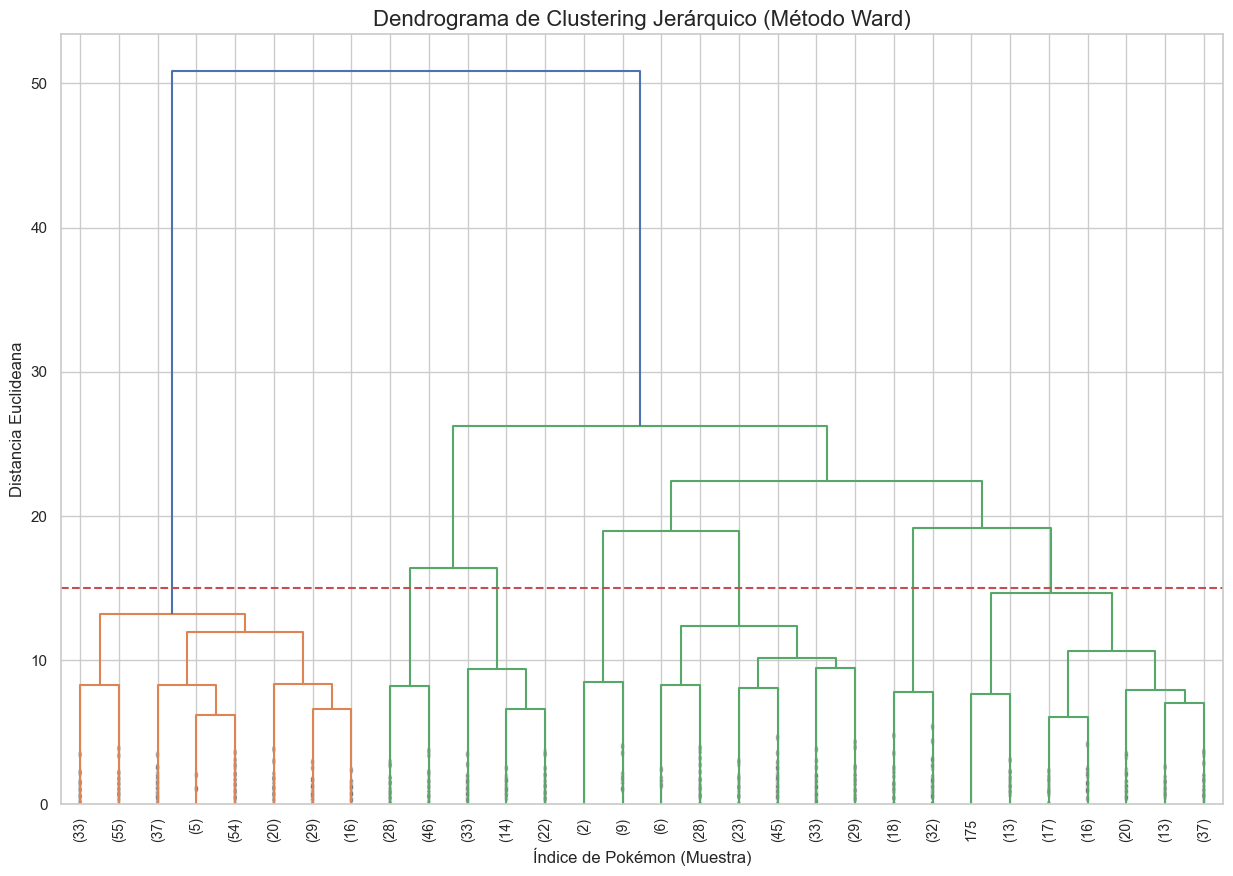

In [21]:
# Calcular la matriz de enlace usando el método 'ward'
# Ward minimiza la varianza dentro de los clústeres al fusionarlos.
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(15, 10))
plt.title('Dendrograma de Clustering Jerárquico (Método Ward)', fontsize=16)
plt.xlabel('Índice de Pokémon (Muestra)', fontsize=12)
plt.ylabel('Distancia Euclideana', fontsize=12)

# Dibujamos el dendrograma
# truncate_mode='lastp': Solo muestra los últimos 'p' clústeres fusionados para que sea legible
dendrogram(linked, 
           truncate_mode='lastp', 
           p=30, 
           leaf_rotation=90., 
           leaf_font_size=10., 
           show_contracted=True)

# Línea de corte
plt.axhline(y=15, color='r', linestyle='--') 
plt.show()

### Celda 4: Evaluación de Métodos de Enlace (Metrics)

Aquí comparamos cuál matemáticas funciona mejor.

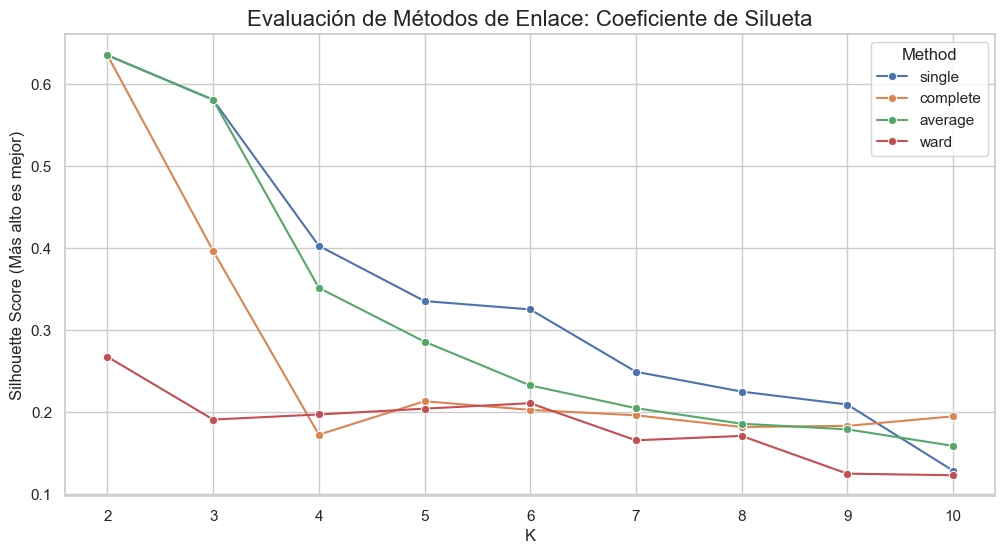

La mejor configuración matemática es:
Method               single
K                         2
Silhouette Score    0.63519
Name: 0, dtype: object


In [22]:
methods = ['single', 'complete', 'average', 'ward']
k_range = range(2, 11) # Probamos de 2 a 10 clusters

results = []

for method in methods:
    #'ward' solo funciona con distancia euclideana
    Z = linkage(X_scaled, method=method)
    
    for k in k_range:
        # fcluster asigna las etiquetas basadas en el corte para k clusters
        labels = fcluster(Z, k, criterion='maxclust')
        
        # Calculamos el Coeficiente de Silueta
        sil_score = silhouette_score(X_scaled, labels)
        
        results.append({
            'Method': method,
            'K': k,
            'Silhouette Score': sil_score
        })

results_df = pd.DataFrame(results)

# Visualizamos cuál es la mejor combinación
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='K', y='Silhouette Score', hue='Method', marker='o')
plt.title('Evaluación de Métodos de Enlace: Coeficiente de Silueta', fontsize=16)
plt.ylabel('Silhouette Score (Más alto es mejor)')
plt.show()

# Mostramos la mejor configuración
best_config = results_df.loc[results_df['Silhouette Score'].idxmax()]
print("La mejor configuración matemática es:")
print(best_config)

### Celda 5: Análisis Específico (Zapdos vs Raichu)

Esta celda responde a la pregunta clave: "¿Zapdos, ZapdosGalar y Raichu se ubican en el mismo grupo?". Buscamos sus etiquetas finales.

            name     type1  hp  atk  def  spa  spe  cluster_hierarchical
21        raichu  Electric  60   90   55   90  110                     2
138       zapdos  Electric  90   90   85  125  100                     2
139  zapdosgalar  Fighting  90  125   90   85  100                     5


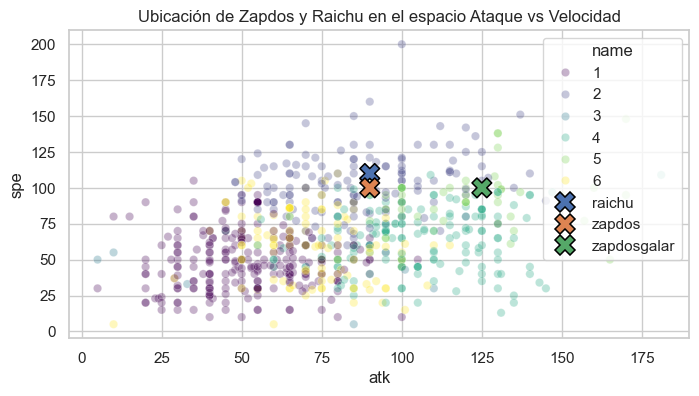

In [23]:
# 1. Aplicamos el modelo final 
k_final = 6
Z_final = linkage(X_scaled, method='ward')
df['cluster_hierarchical'] = fcluster(Z_final, k_final, criterion='maxclust')

# 2. Buscamos a los Pokémon específicos
target_pokemons = ['zapdos', 'zapdosgalar', 'raichu']
# Filtramos por coincidencia parcial si es necesario
subset = df[df['name'].isin(target_pokemons)].copy()

print(subset[['name', 'type1', 'hp', 'atk', 'def', 'spa', 'spe', 'cluster_hierarchical']])

# Visualización rápida de dónde cayeron
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='atk', y='spe', hue='cluster_hierarchical', palette='viridis', alpha=0.3)
sns.scatterplot(data=subset, x='atk', y='spe', hue='name', s=200, edgecolor='black', marker='X')
plt.title('Ubicación de Zapdos y Raichu en el espacio Ataque vs Velocidad')
plt.show()

Celda extra - Mapa de calor

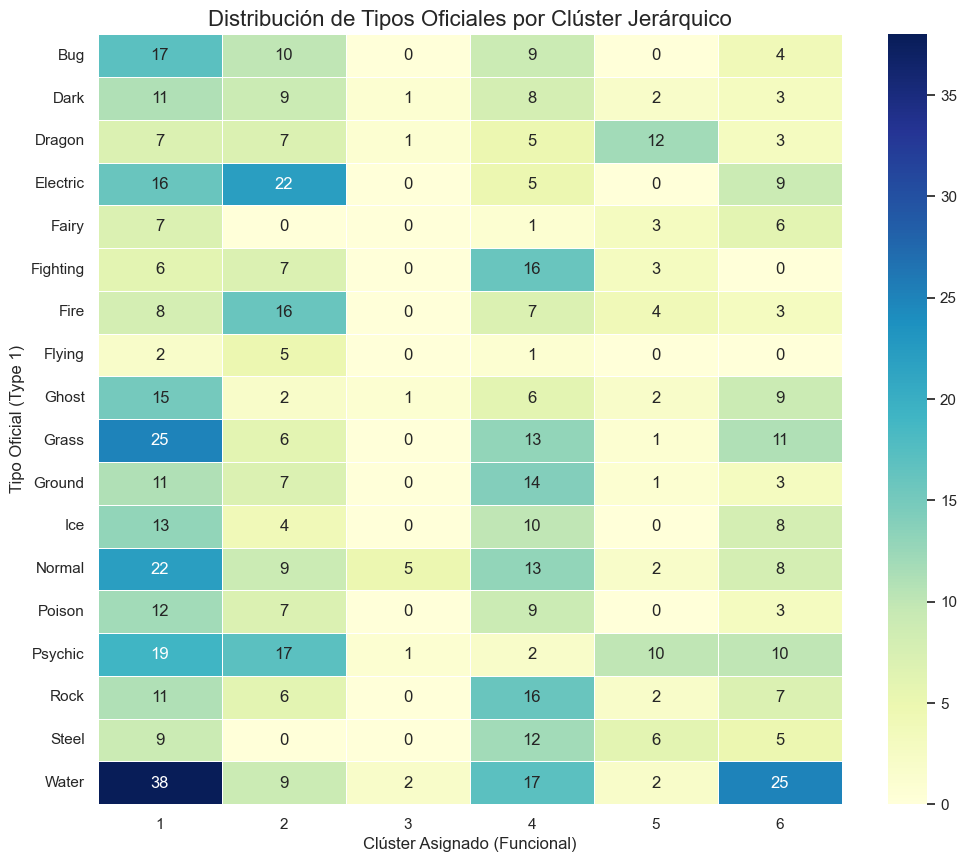

Top 3 tipos más comunes por clúster:

Cluster 1:
type1
Water     38
Grass     25
Normal    22

Cluster 2:
type1
Electric    22
Psychic     17
Fire        16

Cluster 3:
type1
Normal     5
Water      2
Psychic    1

Cluster 4:
type1
Water       17
Fighting    16
Rock        16

Cluster 5:
type1
Dragon     12
Psychic    10
Steel       6

Cluster 6:
type1
Water      25
Grass      11
Psychic    10


In [24]:
# ---------------------------------------------------------
# VISUALIZACIÓN EXTRA: Comparación Clústeres vs Tipos Oficiales
# Para responder a la pregunta: "¿Los grupos difieren de los tipos oficiales?"
# ---------------------------------------------------------

# 1. Crear una Tabla de Contingencia (Crosstab)
# Cuenta cuántos Pokémon de cada Tipo hay en cada Clúster
crosstab = pd.crosstab(df['type1'], df['cluster_hierarchical'])

# 2. Visualizar con un Mapa de Calor (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)

plt.title('Distribución de Tipos Oficiales por Clúster Jerárquico', fontsize=16)
plt.ylabel('Tipo Oficial (Type 1)', fontsize=12)
plt.xlabel('Clúster Asignado (Funcional)', fontsize=12)
plt.show()

# Análisis rápido por pantalla
print("Top 3 tipos más comunes por clúster:")
for cluster in sorted(df['cluster_hierarchical'].unique()):
    top_types = df[df['cluster_hierarchical'] == cluster]['type1'].value_counts().head(3)
    print(f"\nCluster {cluster}:")
    print(top_types.to_string())